## Description
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of solving advection-diffusion  using multigrid method in three-dimensional space implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Prerequisites

In [1]:
## Install the required dependencies
! python -m pip install mpi4py
! mkdir serial_out
! mkdir parallel_out
! mkdir norms
! mkdir parallel_steps
# ! mkdir sub_domains
# ! mkdir test_output
! mkdir residuals
! mkdir parallel_residuals
import numpy as np
import matplotlib.pyplot as plt

mkdir: serial_out: File exists
mkdir: parallel_out: File exists
mkdir: norms: File exists
mkdir: parallel_steps: File exists
mkdir: residuals: File exists
mkdir: parallel_residuals: File exists


## Tool functions

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# view 3D result from xy, yz, xz planes
def plot_cube(result_cube, view_loc):
  fig, ax = plt.subplots(1,3, figsize=[20,5])
  plt.subplot(1,3,1)
  plt.imshow(result_cube[0,:,:,view_loc,0], cmap='jet')
  plt.colorbar()
  plt.title('central yz plane',Fontsize=20)
  plt.subplot(1,3,2)
  plt.imshow(result_cube[0,:,view_loc,:,0], cmap='jet')
  plt.colorbar()
  plt.title('central xz plane',Fontsize=20)
  plt.subplot(1,3,3)
  plt.imshow(result_cube[0,view_loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('central xy plane',Fontsize=20)

def plot_cube_3D(result_cube):
  # Create axis
  x,y,z = result_cube.shape
  axes = [x, y, z]

  # Create Data
  # data = np.ones(axes, dtype=np.bool)
  data = result_cube
  
  # Control Transparency
  alpha = 0.9
  
  # Control colour
  colors = np.empty(axes + [4], dtype=np.float32)
  
  colors[:] = [1, 0, 0, alpha]  # red
  
  # Plot figure
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  
  # Voxels is used to customizations of the
  # sizes, positions and colors.
  ax.voxels(data, facecolors=colors)

## Problem Details
Recall the [CFD model](https://www.imperial.ac.uk/people/c.heaney/document/9723/AI_for_CFD_v1b/?AI_for_CFD_v1b.pdf) Boyang et al. have implemented for solving 2D advection-diffusion equation, Burger equation with TensorFlow. Based on the idea in the proceeding work, here we apply multi-grid method to solve advection-diffusion equation in 3D space.           

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $.  (e.g. 2D Advection- diffusion equation)          

Now we consider:
Using 7-stencil and multigrid method to solve a advection-diffusion problem in 3D space. In this problem, we have a constant heat source located in the centre of the cube and observe the movement of it with respect to the time.

$\frac{\partial T}{\partial t} + u\frac{\partial T}{\partial x}+ v\frac{\partial T}{\partial y} = \nu \nabla^2T $.  (e.g. 3D Advection- diffusion equation in steady-state)   

<!-- in which T is a scalar concentration field with size 300m by 300m,$t$ is time, ($u,v$) are the advection velocities.$\sigma$,$\nu$ and $s$ respectively are the absorption term, constant diffusivity and source term. Boundary conditions fixed zero solutions at the edges of the domain (No-flux boundary condition). Note for the equation formulated in this work, $\sigma = s = 0$ and advection velocity is fixed with ($1ms^{-1},1ms^{-1}$). So the expected pattern for those two initialised distributions are to be advected to the upper-right corner while diffused with constant coefficient. -->

## Serial implementation

### Initial condition

values.shape:  (1, 128, 128, 128, 1)


2022-12-03 16:25:07.090607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Text(0.5, 1.0, 'central xy plane')

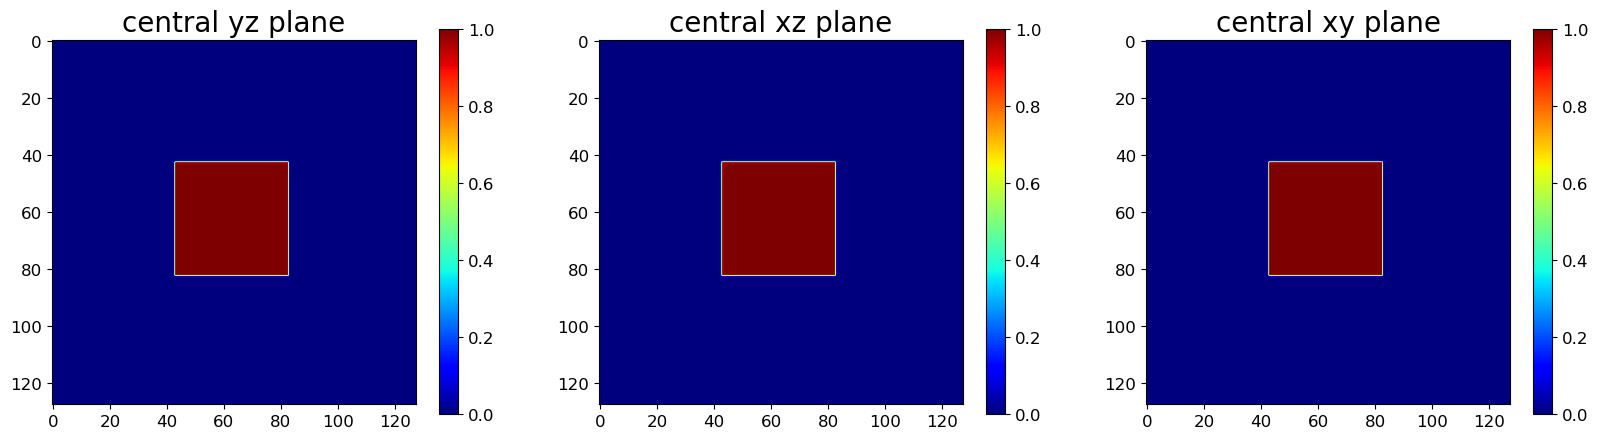

In [3]:
import numpy as np 
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

dt = 0.1
dx = 1 
Dx = 100.0
Dy = 100.0
Dz = 100.0
# what are these terms in diff dimesions?
ub = 500 # what is this term? 

# the weights matrix (in 3D)
alpha = 1 # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128
ny = 128
nz = 128

T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
# initialise t:
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

# generate the constant heat source
for ii in range(nx):
    x[0][ii] = -63.5 + 128/nx*ii
    y[0][ii] = -63.5 + 128/nx*ii    
    z[0][ii] = -63.5 + 128/nx*ii

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+43][j+43][k+43] = 1 

input_shape = (1,nx,ny,nz,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)

temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))
values = temp1

# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[20,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,63,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,63,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,63,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

### Serial multigrid 3D

In [2]:
#============================== Imports ==================================#

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue


# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import math
import time

#============================== Initialization of problem ==================================#
dx = 1       # Grid size in x    
dy = 1       # Grid size in y       
dz = 1       # Grid size in z    
Dx = 100.0   # Conductivity in x    
Dy = 100.0   # Conductivity in y
Dz = 100.0    # Conductivity in z
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in y
nz = 128     # Grid point in z

# the weights matrix
w1 = np.zeros([1,2,2,2,1])
w2 = np.zeros([1,3,3,3,1])
w1[0,:,:,:,0] = 0.125
pd1 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
pd2 = [[0.0, 1.0*Dy/dy**2,  0.0],
       [1.0*Dx/dx**2,  -(2*Dx/dx**2+2*Dy/dy**2+2*Dz/dz**2),  1.0*Dx/dx**2],
       [0.0, 1.0*Dy/dy**2,  0.0]]
pd3 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
w2[0,0,:,:,0] = -np.array(pd1) 
w2[0,1,:,:,0] = -np.array(pd2) 
w2[0,2,:,:,0] = -np.array(pd3) 

#============================== Initialization CNN layers ==================================#
kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

# CNN layers
CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

#============================== Restriction process ==================================#
CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    
CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])


#============================== Prolongation process ==================================#
CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

#============================== Initial Condition ==================================#
T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+43][j+43][k+43] = 1 

input_shape = (1,nx,ny,nz,1)
values = tf.zeros(input_shape,dtype=tf.float32)
print('values.shape: ', values.shape)

#============================== Skipping layer ==================================#

temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))
values = temp1
b = values # only for one time step
multi_itr = 100
j_itr = 1 # Jacobi iteration number

start_time = time.perf_counter()

for multi_grid in range(multi_itr):    
    w_2 = np.zeros([1,2,2,2,1])
    r = CNN3D_A_128(values) - b # compute the residual errors
    
    np.save('residuals/multigrid_3d_res.npy',r)

    # the restriction           
    r_64 = CNN3D_res_128(r) #32
    r_32 = CNN3D_res_64(r_64) #16
    r_16 = CNN3D_res_32(r_32) #8
    r_8 = CNN3D_res_16(r_16) #4
    r_4 = CNN3D_res_8(r_8) #2
    r_2 = CNN3D_res_4(r_4) #1 for the parallel
    # r_1 = CNN3D_res_2(r_2)

    # np.save("/content/residuals/serial_residual",r_2)

    # I suppose here is the proess of Jacobi smoothing followed by prolongation (and correction)
    # for Jacobi in range(j_itr):
        # w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]

    # w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]

    # w_2 = CNN3D_prol_1(w)                   
    for Jacobi in range(j_itr):
        w_2 = w_2 - CNN3D_A_2(w_2)/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]
    # w_2 = w_2 - CNN3D_A_2(w_2)/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]

    w_4 = CNN3D_prol_2(w_2) 
    for Jacobi in range(j_itr):
        w_4 = w_4 - CNN3D_A_4(w_4)/w2[0,1,1,1,0] + r_4/w2[0,1,1,1,0]

    w_8 = CNN3D_prol_4(w_4) 
    for Jacobi in range(j_itr):
        w_8 = w_8 - CNN3D_A_8(w_8)/w2[0,1,1,1,0] + r_8/w2[0,1,1,1,0]

    w_16 = CNN3D_prol_8(w_8) 
    for Jacobi in range(j_itr):
        w_16 = w_16 - CNN3D_A_16(w_16)/w2[0,1,1,1,0] + r_16/w2[0,1,1,1,0]

    w_32 = CNN3D_prol_16(w_16) 
    for Jacobi in range(j_itr):
        w_32 = w_32 - CNN3D_A_32(w_32)/w2[0,1,1,1,0] + r_32/w2[0,1,1,1,0]
    
    w_64 = CNN3D_prol_32(w_32)
    for Jacobi in range(j_itr):
        w_64 = w_64 - CNN3D_A_64(w_64)/w2[0,1,1,1,0] + r_64/w2[0,1,1,1,0]
    
    w_128 = CNN3D_prol_64(w_64)
    w_128 = w_128 - CNN3D_A_128(w_128)/w2[0,1,1,1,0] + r/w2[0,1,1,1,0]

    values = values - w_128 
    values = values - CNN3D_A_128(values)/w2[0,1,1,1,0] + b/w2[0,1,1,1,0]

end_time = time.perf_counter()
# save final result and the prolongation
np.save("serial_out/serial_AD_multigrid_3D_result.npy",values)
np.save("serial_out/serial_AD_multigrid_3D_w2.npy",w_2)
np.save("serial_out/serial_AD_multigrid_3D_w4.npy",w_4)
np.save("serial_out/serial_AD_multigrid_3D_w8.npy",w_8)
np.save("serial_out/serial_AD_multigrid_3D_w16.npy",w_16)
np.save("serial_out/serial_AD_multigrid_3D_w32.npy",w_32)
np.save("serial_out/serial_AD_multigrid_3D_w64.npy",w_64)
np.save("serial_out/serial_AD_multigrid_3D_w128.npy",w_128)

print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using serial multigrid.")
# around 200 seconds

values.shape:  (1, 128, 128, 128, 1)
[INFO] Problem solved in 43.1002 seconds using serial multigrid.


## MPI Subroutine

## Parallelisation example
solve 8 (64,64,64) sub-cubes in parallel.

### Initial condition

values.shape:  (1, 124, 124, 124, 1)


Text(0.5, 1.0, 'central xy plane')

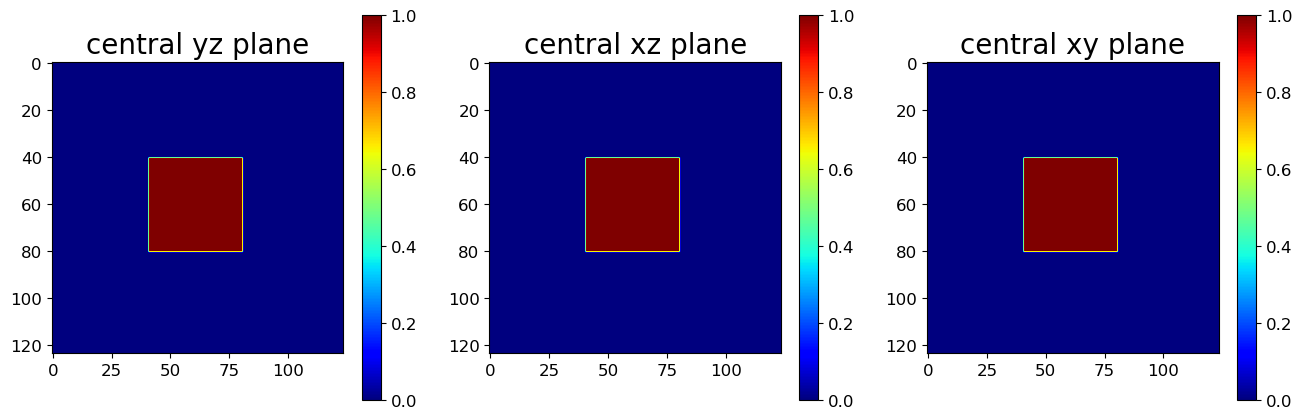

In [5]:
# we adjust the shape of the problem to (124,124,124)
import numpy as np 
import math
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

dt = 0.1
dx = 1 
Dx = 200.0
Dy = 100.0
Dz = 50.0
# what are these terms in diff dimesions?
ub = 500 # what is this term? 

# the weights matrix (in 3D)
alpha = 1 # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 124
ny = 124
nz = 124

T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
# initialise t:
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+41][j+41][k+41] = 1 

input_shape = (1,nx,ny,nz,1)
values = tf.zeros(input_shape)
print('values.shape: ', values.shape)

temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(T.astype('float32')))
values = temp1

# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(values[0,:,:,61,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(values[0,:,61,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(values[0,61,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

### Parallel multigrid 3D

In [3]:
%%writefile parallel_multigrid_3D.py

#============================== Imports ==================================#
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid tf dnn flag issue

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import math
from time import perf_counter

from halo_exchange_upgraded import HaloExchange

#============================== Initialization of original problem ==================================#
dx = 1       # Grid size in x    
dy = 1       # Grid size in y       
dz = 1       # Grid size in z    
Dx = 100.0   # Conductivity in x    
Dy = 100.0   # Conductivity in y
Dz = 100.0    # Conductivity in z
# Parameters for the computational domain
alpha = 1    # relaxation coefficient for Jacobi iteration (from 0 to 1)
nx = 128     # Grid point in x
ny = 128     # Grid point in y
nz = 128     # Grid point in z

# the weights matrix
w1 = np.zeros([1,2,2,2,1])
w2 = np.zeros([1,3,3,3,1])
w1[0,:,:,:,0] = 0.125
pd1 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
pd2 = [[0.0, 1.0*Dy/dy**2,  0.0],
       [1.0*Dx/dx**2,  -(2*Dx/dx**2+2*Dy/dy**2+2*Dz/dz**2),  1.0*Dx/dx**2],
       [0.0, 1.0*Dy/dy**2,  0.0]]
pd3 = [[0.0, 0.0,  0.0],
       [0.0, 1.0*Dz/dz**2,  0.0],
       [0.0, 0.0,  0.0]]
w2[0,0,:,:,0] = -np.array(pd1) 
w2[0,1,:,:,0] = -np.array(pd2) 
w2[0,2,:,:,0] = -np.array(pd3) 

kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)) )

T = np.zeros([nx,ny,nz]) # problem space (128,128,128)
gamma = 10
x0 = 0 
y0 = 0
z0 = 0
x = np.zeros([1,nx])
y = np.zeros([1,ny])
z = np.zeros([1,nz])

for i in range(40):
    for j in range(40):
        for k in range(40):
            T[i+43][j+43][k+43] = 1 

# T -> (1,128,128,128,1)
he = HaloExchange(structured=True,tensor_used=True,double_precision=True,corner_exchanged=True)
sub_nx, sub_ny, sub_nz,current_domain = he.initialization(T,is_periodic=False,is_reordered=False)

input_shape = (1,sub_nx+2,sub_ny+2,sub_nz+2,1)
values = tf.zeros(input_shape,tf.float32)
rank = he.rank # get the process rank

# update halo once as the start
current_domain = he.structured_halo_update_3D(current_domain)
# print(current_domain.shape)
current_domain = current_domain.numpy().reshape(sub_nx+2, sub_ny+2, sub_nz+2)

#============================== Initialization CNN layers ==================================#
# CNN layers
CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer)
])

CNN3D_A_66 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(66, 66, 66, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_34 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(34, 34, 34, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_18 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(18, 18, 18, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_10 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(10, 10, 10, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_6 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(6, 6, 6, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_3 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(3, 3, 3, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

#============================== Restriction process ==================================#

CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),   
])    

CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer), 
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])
CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])


#============================== Prolongation process ==================================#
CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

#============================== Skipping layer ==================================#
start_time =  perf_counter()

# F-cycle multigrid method
temp1 = tf.Variable(values)
temp1[0,:,:,:,0].assign(temp1[0,:,:,:,0]+tf.convert_to_tensor(current_domain.astype('float32'))) # for parallel we add subdomain
values = temp1

# b = values # only for one time step
b = tf.reshape(values[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_ny,1))           # only for one time step
multi_itr = 100
j_itr = 1 # Jacobi iteration number


# halo-update at each Jacobi iteration
for multi_grid in range(multi_itr):
    w = np.zeros([1,1,1,1,1])
    r = CNN3D_A_66(values) - b # compute the residual
    
    np.save('parallel_residuals/parallel_multigrid_3d_res_{}'.format(rank),r)
    
    # r_64 = CNN3D_res_128(r) 
    r_32 = CNN3D_res_64(r) # 128
    r_16 = CNN3D_res_32(r_32) # 64
    r_8 = CNN3D_res_16(r_16) # 32
    r_4 = CNN3D_res_8(r_8) # 16
    r_2 = CNN3D_res_4(r_4) # 8
    r_1 = CNN3D_res_2(r_2) # 4

    # I suppose here is the proess of Jacobi smoothing followed by prolongation (and correction)
    for Jacobi in range(j_itr):
        w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]
    w = w - CNN3D_A_1(w)/w2[0,1,1,1,0] + r_1/w2[0,1,1,1,0]

    w_2 = CNN3D_prol_1(w)
    w_t1 = he.padding_block_halo_3D(w_2,1)
    w_t1 = he.structured_halo_update_3D(w_t1)
    for Jacobi in range(j_itr):
      temp = CNN3D_A_4(w_t1)
      w_2 = w_2 - temp/w2[0,1,1,1,0] + r_2/w2[0,1,1,1,0]

    w_4 = CNN3D_prol_2(w_2)
    w_t2 = he.padding_block_halo_3D(w_4,1)
    w_t2 = he.structured_halo_update_3D(w_t2)
    for Jacobi in range(j_itr):
      temp = CNN3D_A_6(w_t2)
      w_4 = w_4 - temp/w2[0,1,1,1,0] + r_4/w2[0,1,1,1,0]

    w_8 = CNN3D_prol_4(w_4)
    w_t3 = he.padding_block_halo_3D(w_8,1)
    w_t3 = he.structured_halo_update_3D(w_t3)
    for Jacobi in range(j_itr):
      temp = CNN3D_A_10(w_t3)
      w_8 = w_8 - temp/w2[0,1,1,1,0] + r_8/w2[0,1,1,1,0]

    w_16 = CNN3D_prol_8(w_8)
    w_t4 = he.padding_block_halo_3D(w_16,1)
    w_t4 = he.structured_halo_update_3D(w_t4)  
    for Jacobi in range(j_itr):
      temp = CNN3D_A_18(w_t4)
      w_16 = w_16 - temp/w2[0,1,1,1,0] + r_16/w2[0,1,1,1,0]

    w_32 = CNN3D_prol_16(w_16) 
    w_t5 = he.padding_block_halo_3D(w_32,1)
    w_t5 = he.structured_halo_update_3D(w_t5)  
    for Jacobi in range(j_itr):
      temp = CNN3D_A_34(w_t5)
      w_32 = w_32 - temp/w2[0,1,1,1,0] + r_32/w2[0,1,1,1,0]

    w_64 = CNN3D_prol_32(w_32) 
    w_t6 = he.padding_block_halo_3D(w_64,1)
    w_t6 = he.structured_halo_update_3D(w_t6)  
    for Jacobi in range(j_itr):
      temp = CNN3D_A_66(w_t6)
      w_64 = w_64 - temp/w2[0,1,1,1,0] + r/w2[0,1,1,1,0]
      
    w_64 = he.padding_block_halo_3D(w_64,1)
    w_64 = he.structured_halo_update_3D(w_64)

    values = values - w_64
    tempVal = tf.reshape(values[0,1:-1,1:-1,1:-1,0],(1,sub_nx,sub_ny,sub_nz,1))
    tempVal = tempVal - CNN3D_A_66(values)/w2[0,1,1,1,0] + b/w2[0,1,1,1,0]
    values = he.padding_block_halo_3D(tempVal,1)
    values = he.structured_halo_update_3D(values)
    
end_time = perf_counter()

# save final result and the prolongations (residual on different grids)
np.save("parallel_out/parallel_AD_multigrid_3D_result_proc_{}.npy".format(rank),values)
np.save("parallel_out/parallel_AD_multigrid_3D_w_proc_{}.npy".format(rank),w)
np.save("parallel_out/parallel_AD_multigrid_3D_w2_proc_{}.npy".format(rank),w_2)
np.save("parallel_out/parallel_AD_multigrid_3D_w4_proc_{}.npy".format(rank),w_4)
np.save("parallel_out/parallel_AD_multigrid_3D_w8_proc_{}.npy".format(rank),w_8)
np.save("parallel_out/parallel_AD_multigrid_3D_w16_proc_{}.npy".format(rank),w_16)
np.save("parallel_out/parallel_AD_multigrid_3D_w32_proc_{}.npy".format(rank),w_32)
np.save("parallel_out/parallel_AD_multigrid_3D_w64_proc_{}.npy".format(rank),w_64)

print(f"[INFO] Problem solved in {end_time - start_time:0.4f} seconds using parallel multigrid.")

Overwriting parallel_multigrid_3D.py


## Run the parallel code

In [7]:
! export TMPDIR=/tmp
! mpiexec -n 8 python parallel_multigrid_3D.py

# A system call failed during shared memory initialization that should
# not have.  It is likely that your MPI job will now either abort or
# experience performance degradation.

# Troubleshooting this: export TMPDIR=/tmp

[INFO] Problem solved in 64.5000 seconds using parallel multigrid.
[INFO] Problem solved in 64.3537 seconds using parallel multigrid.
[INFO] Problem solved in 64.3456 seconds using parallel multigrid.
[INFO] Problem solved in 64.4450 seconds using parallel multigrid.
[INFO] Problem solved in 64.3659 seconds using parallel multigrid.
[INFO] Problem solved in 64.3833 seconds using parallel multigrid.
[INFO] Problem solved in 64.2371 seconds using parallel multigrid.
[INFO] Problem solved in 64.4891 seconds using parallel multigrid.
--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  shuheng-mos-MacBook-Air.local
  System call: unlink(2) /var/folders/7h/m14q6_7934g5kkp_8sh_875m0000gn/T//ompi.shuheng-mos-MacBook-Air.501/pid.70524/1/vader_segment.shuheng-mos-MacBook-Air.501.97c40001.

## Check the starting residual

(1, 128, 128, 128, 1)


Text(0.5, 1.0, 'central xy plane')

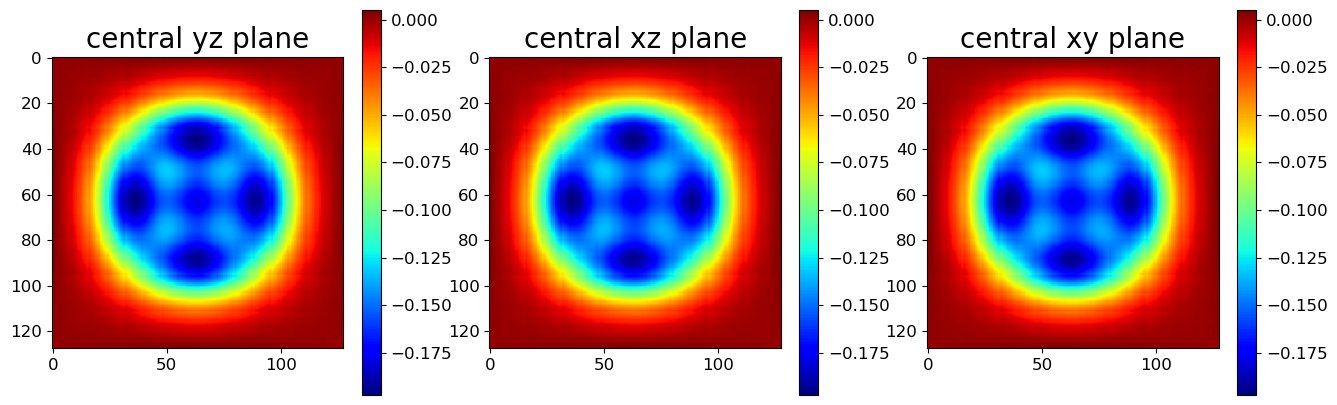

In [4]:
serial_res = np.load('residuals/multigrid_3d_res.npy')
print(serial_res.shape)

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(serial_res[0,:,:,63,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_res[0,:,63,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_res[0,63,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

(1, 128, 128, 128, 1)


Text(0.5, 1.0, 'central xy plane')

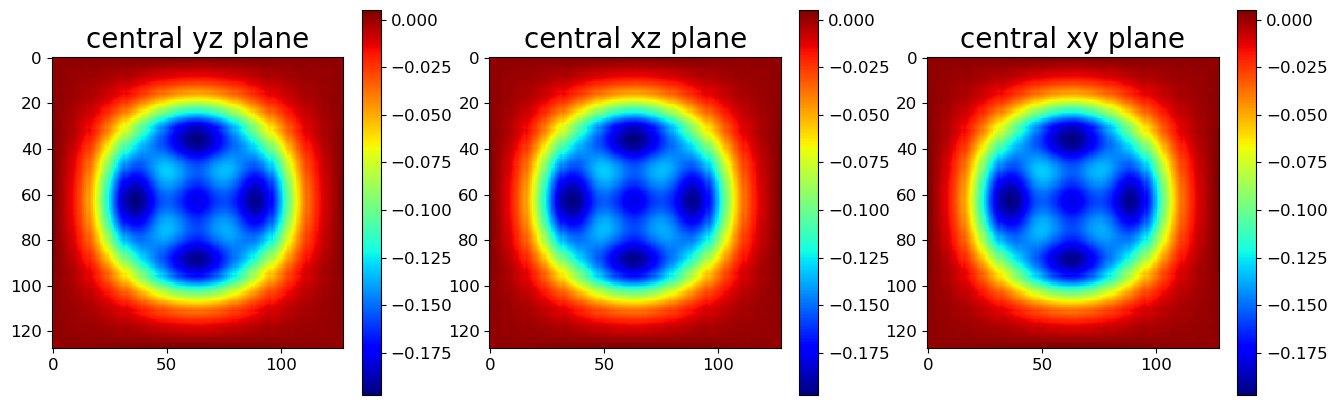

In [5]:
p_res_1 = np.load('parallel_residuals/parallel_multigrid_3d_res_0.npy')
p_res_2 = np.load('parallel_residuals/parallel_multigrid_3d_res_1.npy')
p_res_3 = np.load('parallel_residuals/parallel_multigrid_3d_res_2.npy')
p_res_4 = np.load('parallel_residuals/parallel_multigrid_3d_res_3.npy')
p_res_5 = np.load('parallel_residuals/parallel_multigrid_3d_res_4.npy')
p_res_6 = np.load('parallel_residuals/parallel_multigrid_3d_res_5.npy')
p_res_7 = np.load('parallel_residuals/parallel_multigrid_3d_res_6.npy')
p_res_8 = np.load('parallel_residuals/parallel_multigrid_3d_res_7.npy')

temp1 = np.concatenate([p_res_1,p_res_2], axis = 3)
temp2 = np.concatenate([p_res_3,p_res_4], axis = 3)
level_1 = np.concatenate([temp1, temp2], axis = 2)

temp3 = np.concatenate([p_res_5,p_res_6], axis = 3)
temp4 = np.concatenate([p_res_7,p_res_8], axis = 3)
level_2 = np.concatenate([temp3, temp4], axis = 2)

parallel_8_res = np.concatenate([level_1,level_2], axis=1)
print(parallel_8_res.shape)

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(parallel_8_res[0,:,:,63,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_8_res[0,:,63,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_8_res[0,63,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)


In [6]:
# absolute error
np.sum(np.abs(serial_res.squeeze() - parallel_8_res.squeeze()))

5.267338

## Check the final result

(1, 128, 128, 128, 1)
(128, 128, 128)


Text(0.5, 1.0, 'central xy plane')

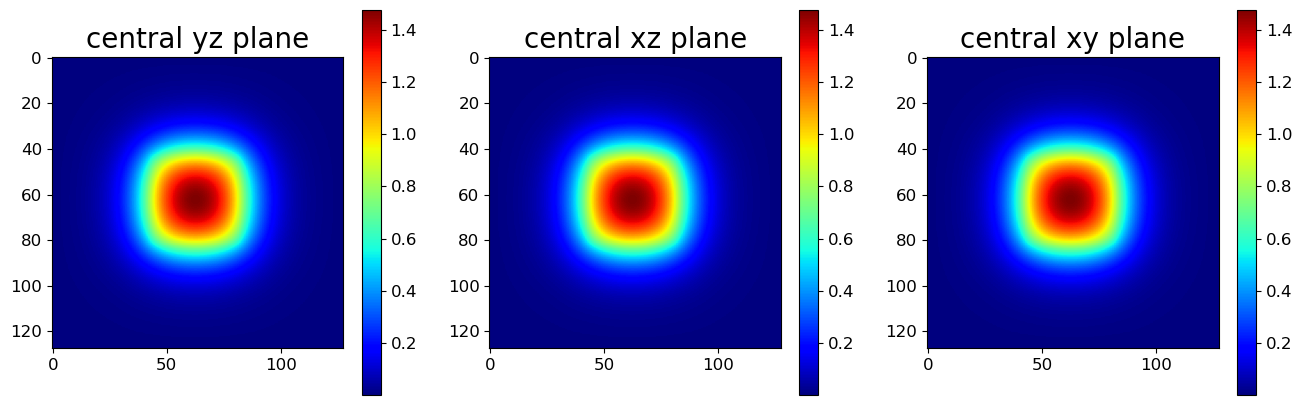

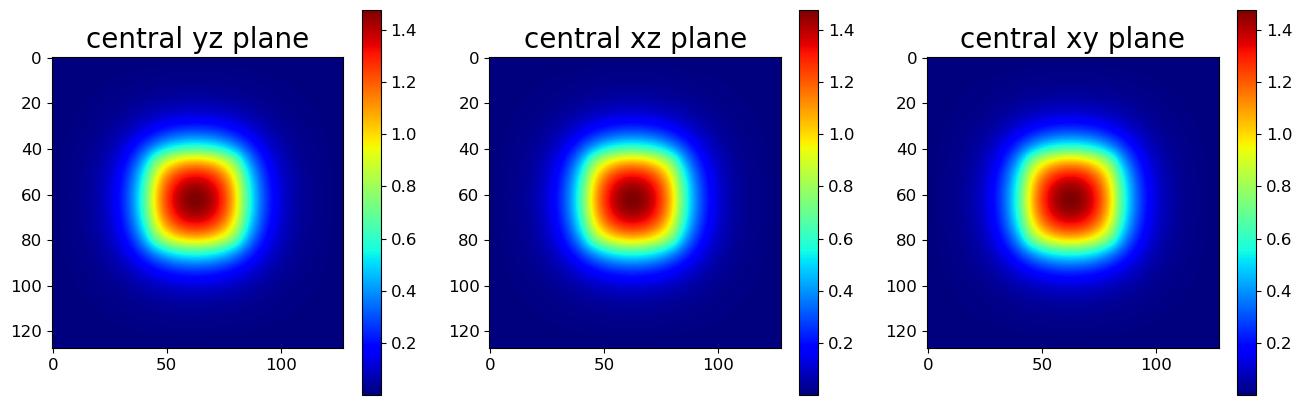

In [7]:
# serial
serial_solution = np.load("serial_out/serial_AD_multigrid_3D_result.npy")
print(serial_solution.shape) 

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(serial_solution[0,:,:,63,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_solution[0,:,63,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_solution[0,63,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

# parallel
pval_1 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_0.npy")[0,1:-1,1:-1,1:-1,0]
pval_2 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_1.npy")[0,1:-1,1:-1,1:-1,0]
pval_3 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_2.npy")[0,1:-1,1:-1,1:-1,0]
pval_4 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_3.npy")[0,1:-1,1:-1,1:-1,0]
pval_5 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_4.npy")[0,1:-1,1:-1,1:-1,0]
pval_6 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_5.npy")[0,1:-1,1:-1,1:-1,0]
pval_7 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_6.npy")[0,1:-1,1:-1,1:-1,0]
pval_8 = np.load("parallel_out/parallel_AD_multigrid_3D_result_proc_7.npy")[0,1:-1,1:-1,1:-1,0]

temp1 = np.concatenate([pval_1,pval_2], axis = 2)
temp2 = np.concatenate([pval_3,pval_4], axis = 2)
level_1 = np.concatenate([temp1, temp2], axis = 1)

temp3 = np.concatenate([pval_5,pval_6], axis = 2)
temp4 = np.concatenate([pval_7,pval_8], axis = 2)
level_2 = np.concatenate([temp3, temp4], axis = 1)

parallel_solution = np.concatenate([level_1,level_2], axis=0)
print(parallel_solution.shape)

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(parallel_solution[:,:,63], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_solution[:,63,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_solution[63,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

In [8]:
# Accuracy analysis
np.sum(np.abs(serial_solution.squeeze() - parallel_solution)) # should be 0.0

0.0063905683

Text(0.5, 1.0, 'central xy plane')

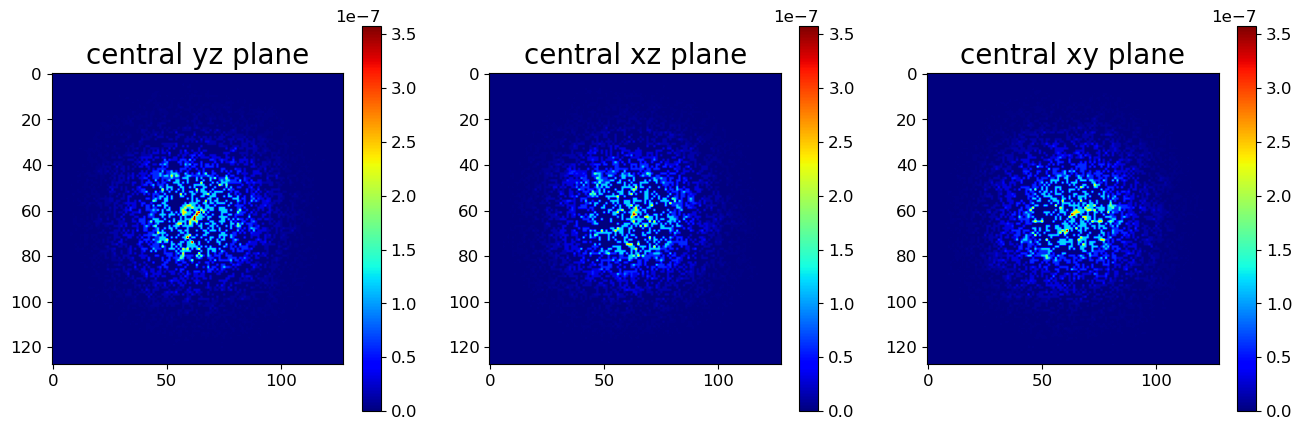

In [9]:
absolute_err = np.abs(np.abs(serial_solution.squeeze() - parallel_solution))

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(absolute_err[:,:,63], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(absolute_err[:,63,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(absolute_err[63,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Check the intermediate residuals

### Coarse-grid (2,2,2)

#### Serial 2x2 residual

(1, 2, 2, 2, 1)


Text(0.5, 1.0, 'central xy plane')

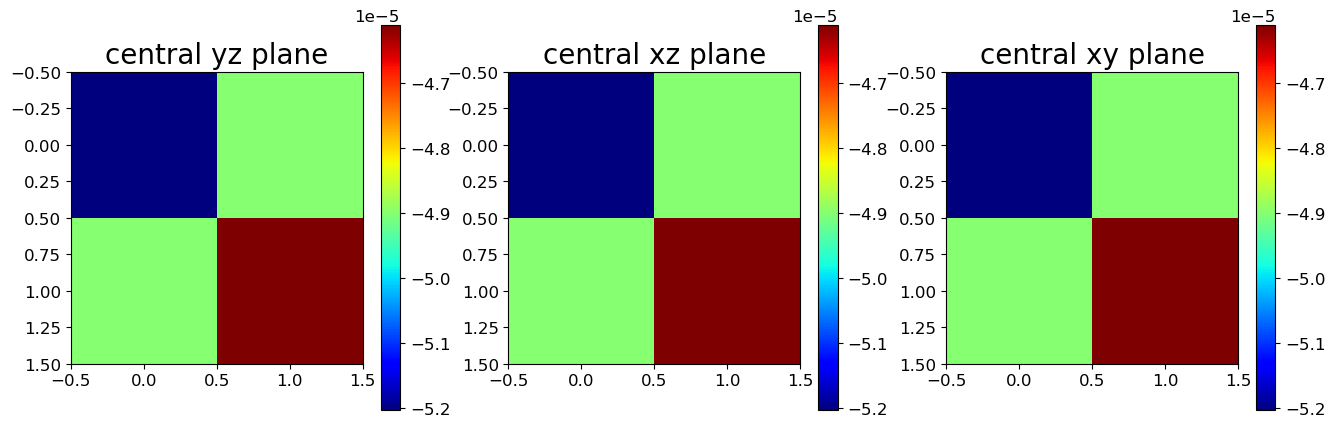

In [10]:
# Here we will check the solution of w4,8,16,32,64,128 prolongation
w_2 = np.load('serial_out/serial_AD_multigrid_3D_w2.npy')
print(w_2.shape)
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(w_2[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_2[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_2[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

#### Parallel 2x2

(1, 2, 2, 2, 1)


Text(0.5, 1.0, 'central xy plane')

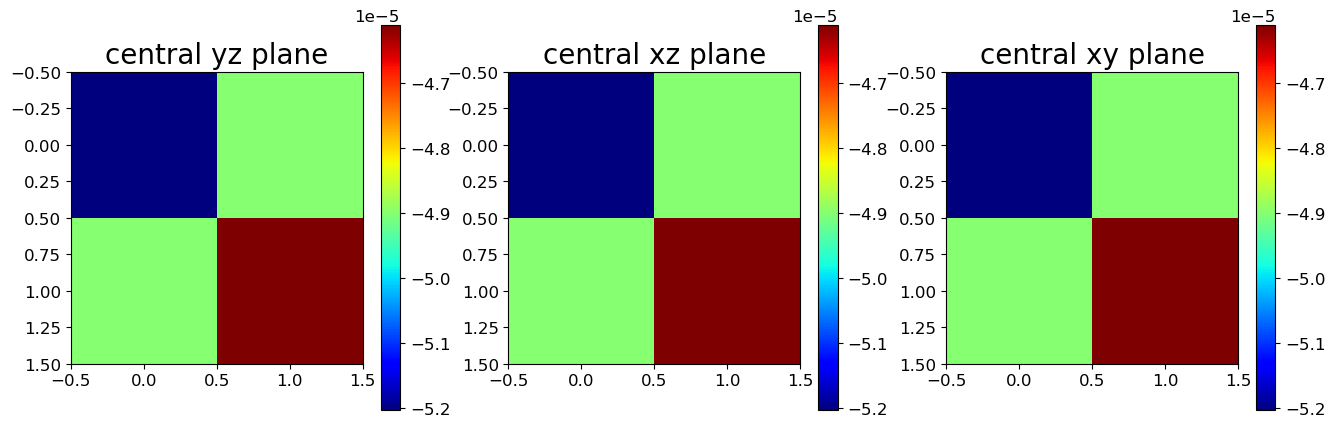

In [11]:
w4_1 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_0.npy")
w4_2 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_1.npy")
w4_3 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_2.npy")
w4_4 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_3.npy")
w4_5 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_4.npy")
w4_6 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_5.npy")
w4_7 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_6.npy")
w4_8 = np.load("parallel_out/parallel_AD_multigrid_3D_w_proc_7.npy")

test1 = np.concatenate([w4_1,w4_2], axis = 3)
test2 = np.concatenate([w4_3,w4_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([w4_5,w4_6], axis = 3)
test4 = np.concatenate([w4_7,w4_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_res_2 = np.concatenate([level_1,level_2], axis=1)
print(parallel_res_2.shape)

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(parallel_res_2[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_res_2[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_res_2[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

In [12]:
w_2.squeeze()

array([[[-5.2034015e-05, -4.8988288e-05],
        [-4.8988302e-05, -4.6104775e-05]],

       [[-4.8988273e-05, -4.6104753e-05],
        [-4.6104753e-05, -4.3376873e-05]]], dtype=float32)

In [13]:
parallel_res_2.squeeze()

array([[[-5.2033996e-05, -4.8988295e-05],
        [-4.8988280e-05, -4.6104738e-05]],

       [[-4.8988299e-05, -4.6104738e-05],
        [-4.6104749e-05, -4.3376866e-05]]], dtype=float32)

## Parallel 4x4 residual

(1, 4, 4, 4, 1)


Text(0.5, 1.0, 'central xy plane')

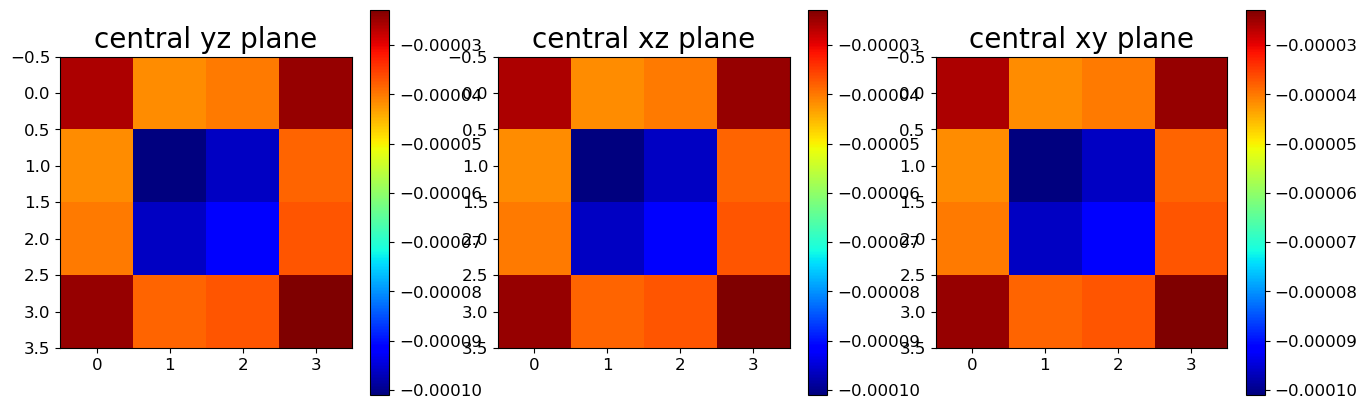

In [14]:
w4_1 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_0.npy")
w4_2 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_1.npy")
w4_3 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_2.npy")
w4_4 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_3.npy")
w4_5 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_4.npy")
w4_6 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_5.npy")
w4_7 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_6.npy")
w4_8 = np.load("parallel_out/parallel_AD_multigrid_3D_w2_proc_7.npy")

test1 = np.concatenate([w4_1,w4_2], axis = 3)
test2 = np.concatenate([w4_3,w4_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([w4_5,w4_6], axis = 3)
test4 = np.concatenate([w4_7,w4_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_8_res = np.concatenate([level_1,level_2], axis=1)
print(parallel_8_res.shape)

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(parallel_8_res[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_8_res[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_8_res[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Serial 4x4 residual

Text(0.5, 1.0, 'central xy plane')

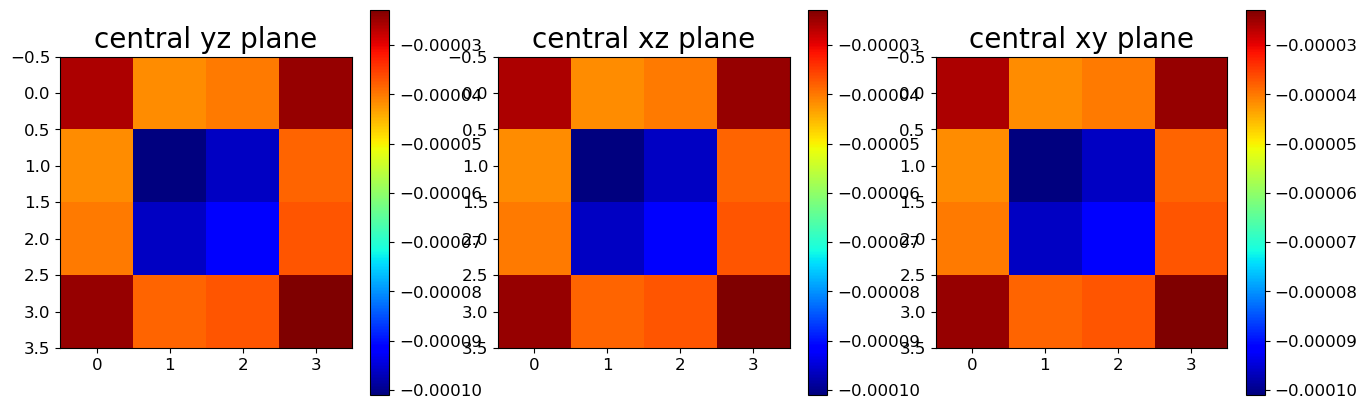

In [15]:
# Here we will check the solution of w4,8,16,32,64,128 prolongation
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(w_4[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_4[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_4[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Parallel 8x8 residual

(1, 8, 8, 8, 1)


Text(0.5, 1.0, 'central xy plane')

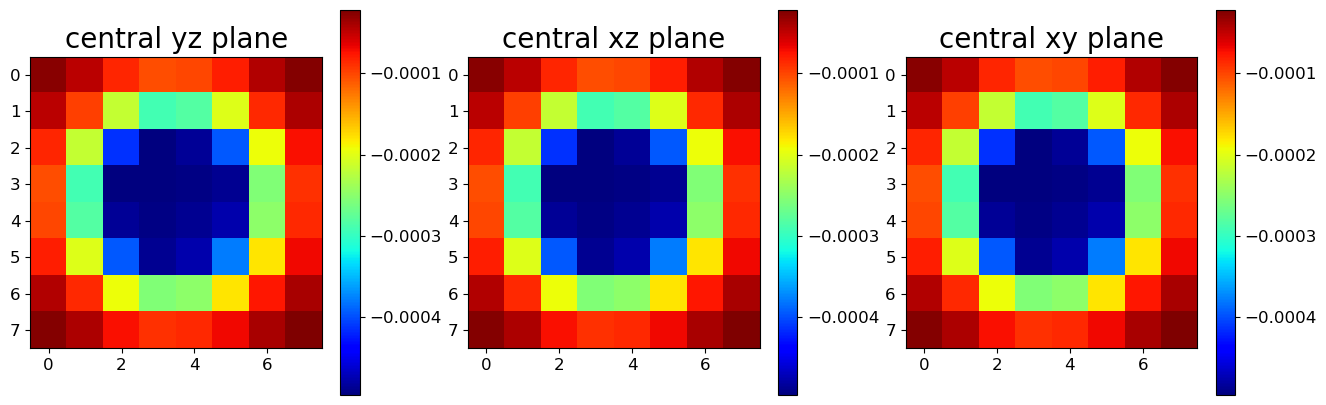

In [16]:
w4_1 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_0.npy")
w4_2 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_1.npy")
w4_3 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_2.npy")
w4_4 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_3.npy")
w4_5 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_4.npy")
w4_6 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_5.npy")
w4_7 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_6.npy")
w4_8 = np.load("parallel_out/parallel_AD_multigrid_3D_w4_proc_7.npy")

test1 = np.concatenate([w4_1,w4_2], axis = 3)
test2 = np.concatenate([w4_3,w4_4], axis = 3)
level_1 = np.concatenate([test1, test2], axis = 2)

test3 = np.concatenate([w4_5,w4_6], axis = 3)
test4 = np.concatenate([w4_7,w4_8], axis = 3)
level_2 = np.concatenate([test3, test4], axis = 2)

parallel_8_res = np.concatenate([level_1,level_2], axis=1)
print(parallel_8_res.shape)

fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(parallel_8_res[0,:,:,3,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_8_res[0,:,3,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_8_res[0,3,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Serial 8x8 residual

Text(0.5, 1.0, 'central xy plane')

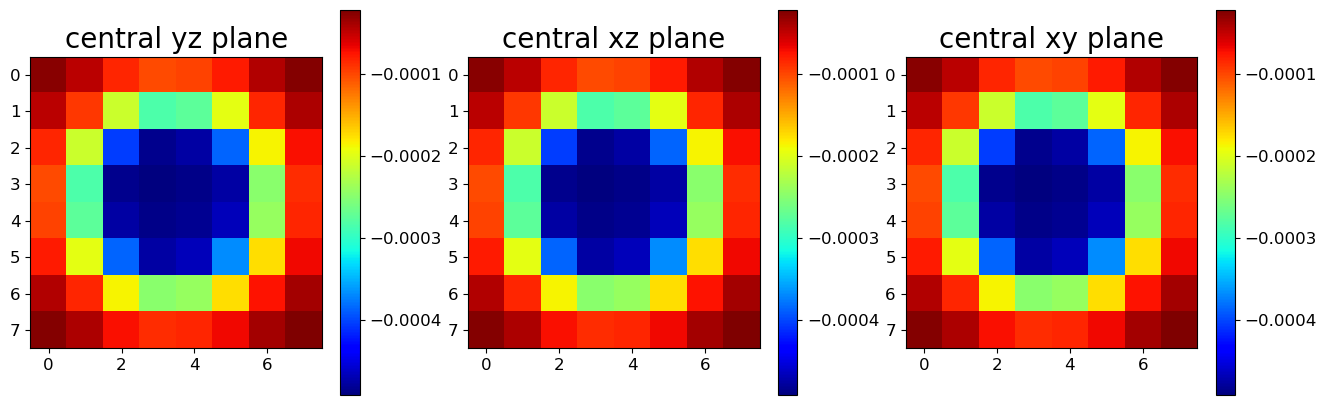

In [17]:
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(w_8[0,:,:,4,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_8[0,:,4,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_8[0,4,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

In [18]:
w_8.shape
parallel_8_res.shape
print(np.sum(np.abs(w_8 - parallel_8_res)))

3.0352567e-08


## Serial 16x16 residual

Text(0.5, 1.0, 'central xy plane')

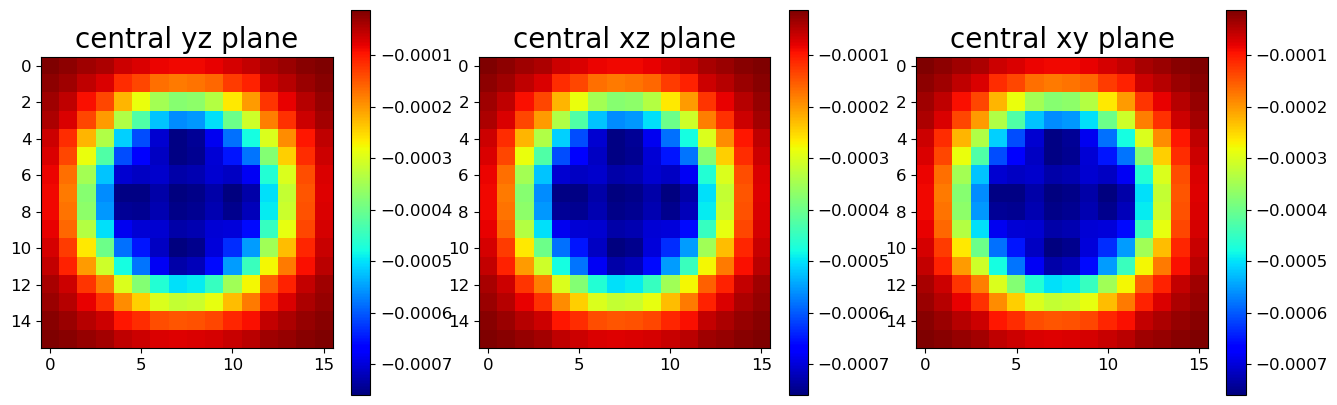

In [19]:
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(w_16[0,:,:,8,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_16[0,:,8,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_16[0,8,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Serial 32x32 residual

Text(0.5, 1.0, 'central xy plane')

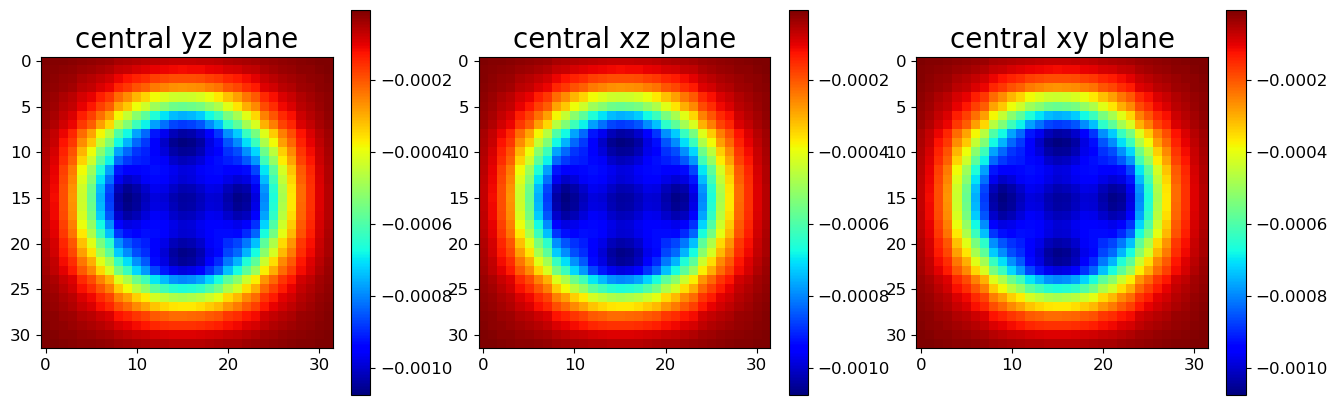

In [20]:
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(w_32[0,:,:,16,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(w_32[0,:,16,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(w_32[0,16,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Serial 64x64 residual

(1, 64, 64, 64, 1)

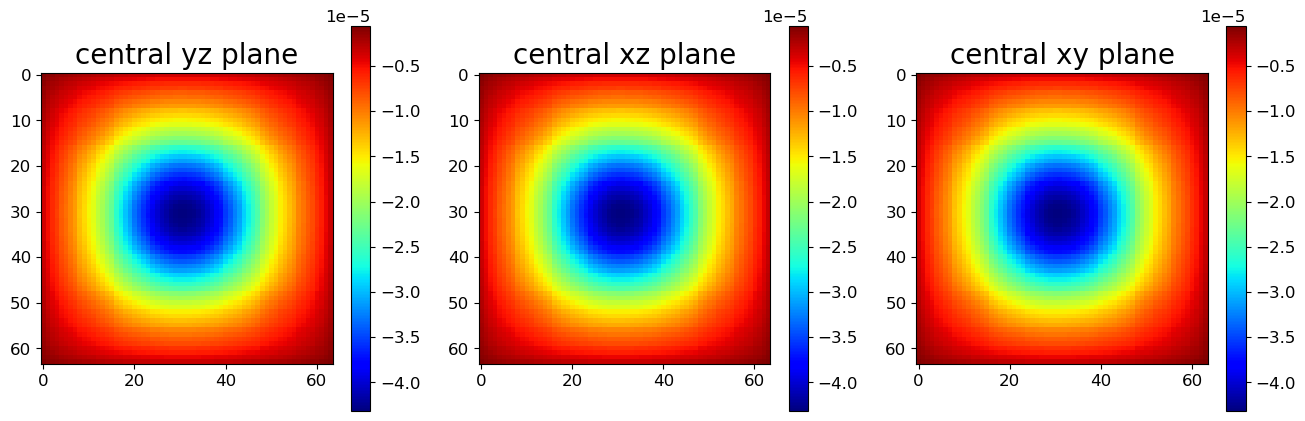

In [21]:
serial_w_64 = np.load('serial_out/serial_AD_multigrid_3D_w64.npy')
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(serial_w_64[0,:,:,63,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_w_64[0,:,63,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_w_64[0,63,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)
serial_w_64.shape

## Parallel 64x64 residual

(64, 64, 64)


Text(0.5, 1.0, 'central xy plane')

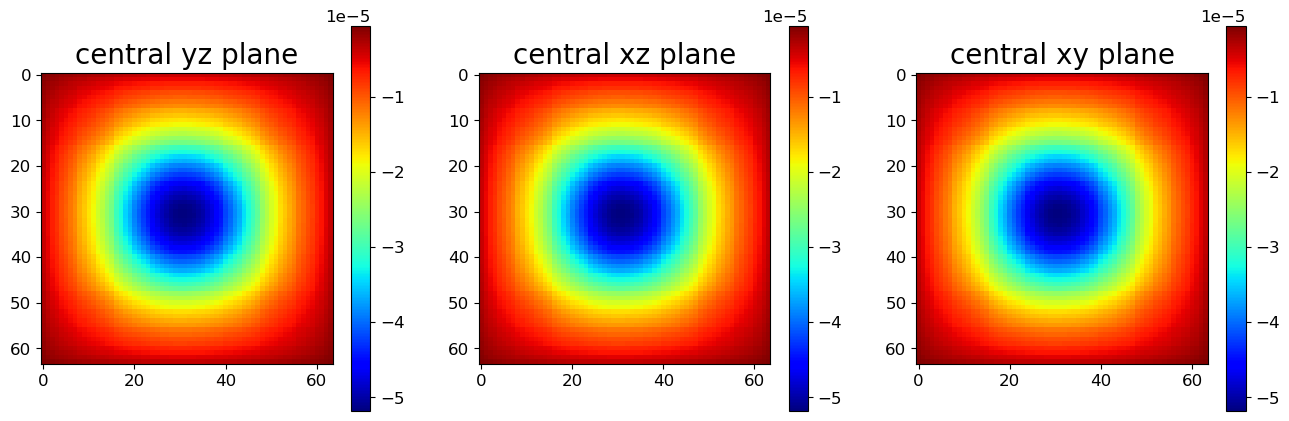

In [22]:
w32_1 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_0.npy")
w32_2 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_1.npy")
w32_3 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_2.npy")
w32_4 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_3.npy")
w32_5 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_4.npy")
w32_6 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_5.npy")
w32_7 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_6.npy")
w32_8 = np.load("parallel_out/parallel_AD_multigrid_3D_w32_proc_7.npy")

# todo: merge the 64 residual into 128 grid residual
temp1 = np.concatenate([w32_1,w32_2], axis = 3)
temp2 = np.concatenate([w32_3,w32_4], axis = 3)
level_1 = np.concatenate([temp1, temp2], axis = 2)

temp3 = np.concatenate([w32_5,w32_6], axis = 3)
temp4 = np.concatenate([w32_7,w32_8], axis = 3)
level_2 = np.concatenate([temp3, temp4], axis = 2)

r_parallel_64 = np.concatenate([level_1,level_2], axis=1)

r_parallel_64 = r_parallel_64[0,:,:,:,0]
print(r_parallel_64.shape)


fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(r_parallel_64[:,:,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(r_parallel_64[:,0,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(r_parallel_64[0,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Serial 128x128 residual

Text(0.5, 1.0, 'central xy plane')

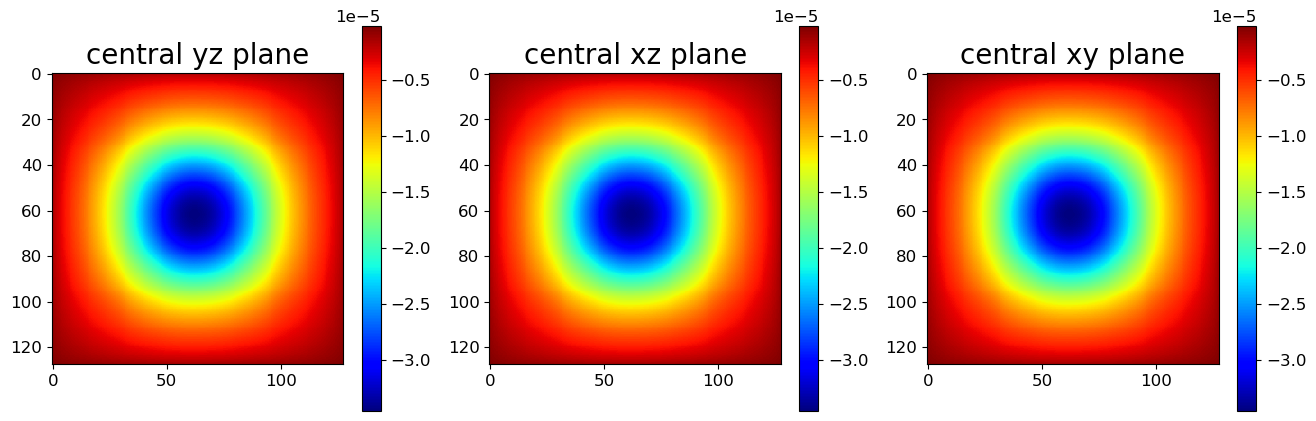

In [23]:
serial_w_128 = np.load('serial_out/serial_AD_multigrid_3D_w128.npy')
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(serial_w_128[0,:,:,0,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_w_128[0,:,0,:,0], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_w_128[0,0,:,:,0], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

## Parallel 128x128 residual

(128, 128, 128)


Text(0.5, 1.0, 'central xy plane')

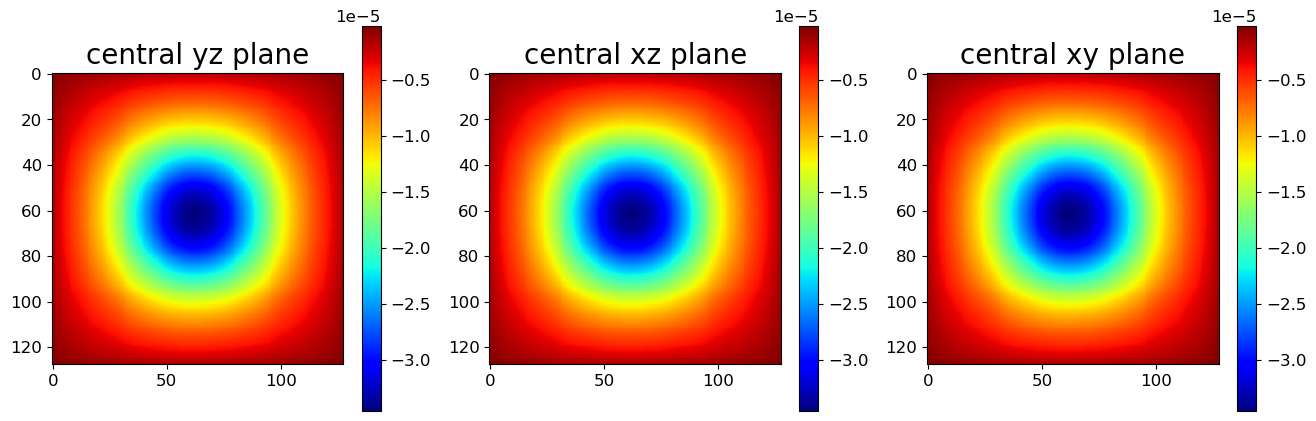

In [24]:
w64_1 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_0.npy")[0,1:-1,1:-1,1:-1,0]
w64_2 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_1.npy")[0,1:-1,1:-1,1:-1,0]
w64_3 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_2.npy")[0,1:-1,1:-1,1:-1,0]
w64_4 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_3.npy")[0,1:-1,1:-1,1:-1,0]
w64_5 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_4.npy")[0,1:-1,1:-1,1:-1,0]
w64_6 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_5.npy")[0,1:-1,1:-1,1:-1,0]
w64_7 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_6.npy")[0,1:-1,1:-1,1:-1,0]
w64_8 = np.load("parallel_out/parallel_AD_multigrid_3D_w64_proc_7.npy")[0,1:-1,1:-1,1:-1,0]


# todo: merge the 64 residual into 128 grid residual
temp1 = np.concatenate([w64_1,w64_2], axis = 2)
temp2 = np.concatenate([w64_3,w64_4], axis = 2)
level_1 = np.concatenate([temp1, temp2], axis = 1)

temp3 = np.concatenate([w64_5,w64_6], axis = 2)
temp4 = np.concatenate([w64_7,w64_8], axis = 2)
level_2 = np.concatenate([temp3, temp4], axis = 1)

r_parallel_128 = np.concatenate([level_1,level_2], axis=0)

# print(r_parallel_128.shape)
# r_parallel_128 = r_parallel_128[0,1:-1,1:-1,1:-1,0]
r_parallel_128 = r_parallel_128
print(r_parallel_128.shape)


fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(r_parallel_128[:,:,0], cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(r_parallel_128[:,0,:], cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(r_parallel_128[0,:,:], cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

In [25]:
np.sum(np.abs(serial_w_128.squeeze()-r_parallel_128))

0.009392905

## Serial solution

(1, 128, 128, 128, 1)

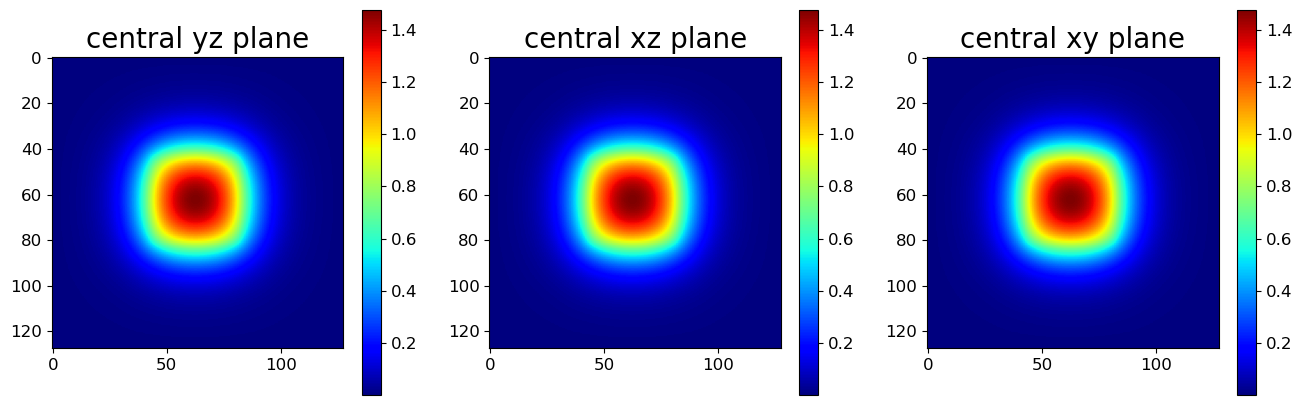

In [26]:
# we can see the result is close to matrix size 64
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(serial_solution[0,:,:,63,0],cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(serial_solution[0,:,63,:,0],cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(serial_solution[0,63,:,:,0],cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)
serial_solution.shape

## Parallel solution

(128, 128, 128)


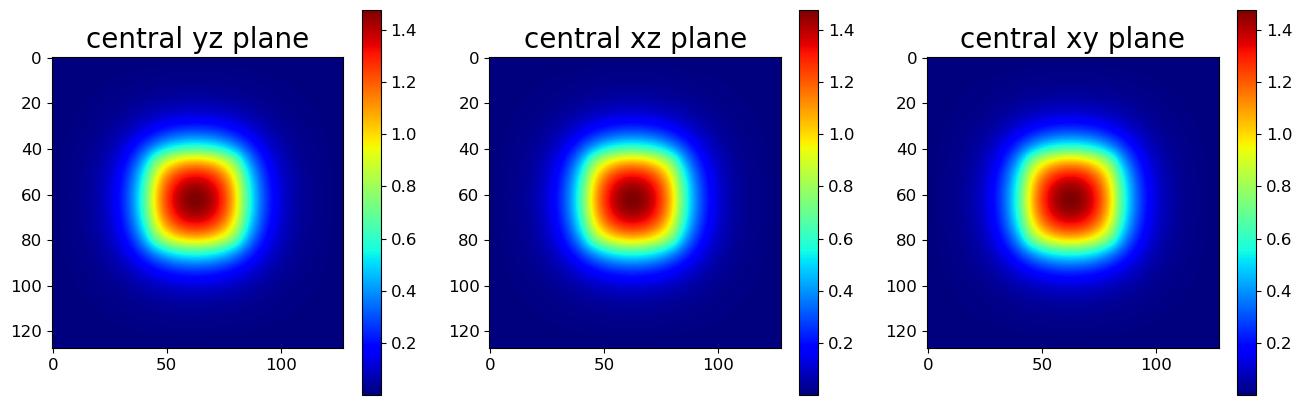

In [27]:
fig, ax = plt.subplots(1,3, figsize=[16,5])
plt.subplot(1,3,1)
plt.imshow(parallel_solution[:,:,63],cmap='jet')
plt.colorbar()
plt.title('central yz plane',fontsize=20)
plt.subplot(1,3,2)
plt.imshow(parallel_solution[:,63,:],cmap='jet')
plt.colorbar()
plt.title('central xz plane',fontsize=20)
plt.subplot(1,3,3)
plt.imshow(parallel_solution[63,:,:],cmap='jet')
plt.colorbar()
plt.title('central xy plane',fontsize=20)

print(parallel_solution.shape)

### Accuracy analysis

In [28]:
import numpy as np

print("ABE: ",np.sum(np.abs(serial_solution.squeeze()) - np.abs(parallel_solution)))

print("AVG ABE of subdomains: ", np.abs(np.sum(serial_solution.squeeze() - parallel_solution))/(128*128*128))

from numpy import linalg as LA
serial_l1 = LA.norm(serial_solution.squeeze())
parallel_l1 = LA.norm(parallel_solution)

# diffs between norm values
print(serial_l1)
print(parallel_l1)
print("Average ABE of norms: ",np.abs(serial_l1 - parallel_l1)/(128*128*128))

ABE:  9.7316166e-05
AVG ABE of subdomains:  4.640396400468205e-11
287.44293
287.44293
Average ABE of norms:  0.0
